In [4]:
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmocean import cm as ccmo
import numpy as np
from datetime import datetime, timedelta

In [5]:
import pytz
eastern = pytz.timezone('US/Eastern')

In [6]:
import glob
from celluloid import Camera
from IPython.display import HTML

In [7]:
class Sailboat():
    def __init__(self, telemetry='min', BB3='min', CI='min', CT='min', O2='min',
                 path=None, date_interval=None, limit=100):
        # Initialized class only containing the PATH or  URL to retrieve data.
        # if PATH:
            # Sailboat(path='some-path')
        # if URL: URL is conructed using:
            # Sailboat(telemetry='min', BB3='min', CI='min', CT='min', O2='min',path=None, date_interval=None, limit=100))
            # Variable groups to request include telemetry, BB3, CI, CT and O2
            # Variable groups can be requested as the full dataset ('all'), or a minimum dataset ('min')
            # Default is 'min' for telemetry, BB3, CI, CT and O2
            # Defult is date_interval=None and limit=100
               
        if path:
            print('path to local file')
            self.type = 'local'
            self.path = path
            self.date_vars = ['GPSTimeStamp']
            
        else:
            print('generating URL')
            self.type = 'remote'
            self.group_options = {'telemetry': telemetry, 'BB3': BB3, 'CI': CI, 'CT': CT, 'O2': O2}
            self.limit = limit
            self.date_interval = date_interval
            self.url = self.gen_url()
            self.date_vars = self.identify_dates()

        
        self.variable_to_column_name = {'time' : 'GPSTimeStamp', 'lon': 'Lon', 'lat': 'Lat',
                            'speed': 'Speed', 'track': 'Track', 'heading': 'Heading', 
                            'pitch': 'Pitch', 'roll': ' Roll',
                            'wind speed': 'WindTrueSpeed', 'wind dir': 'WindTrueDir',
                            'pressure': 'PressureInches', 'air temp': 'AirTemp', 
                            'bb3 time': 'BB3 [Time UTC]',
                            'bb470 counts': 'Bb(470) [counts]', 
                            'bb532 counts': 'Bb(532) [counts]',
                            'bb650  counts':'Bb(650) [counts]',
                            'bb470': 'Bb(470) [NTU]',
                            'bb532': 'Bb(532) [NTU]',
                            'bb650': 'Bb(650) [NTU]', 
                            'ci time': 'CI [Time UTC]',
                            'chla counts': 'Chl. a [counts]',
                            'cdom counts': 'CDOM [counts]',
                            'phyco counts': 'Phycocyanin [counts]',
                            'chla': 'Chl. a [ppb]',
                            'cdom': 'CDOM [QSU]',
                            'phyco': 'Phycocyanin [ppb]',
                            'ct time': 'CT [Time UTC]',
                            'cond': 'Conductivity [mS cm-1]',
                            'temp': 'Temperature [deg C]',
                            'O2 time': 'O2 [Time UTC]',
                            'O2':'O2 Concentration [micromolar]',
                            'O2 sat':'O2 Saturation [%]',
                            'O2 temp': 'O2 Temperature [deg C]',
                           }
        
    
    def gen_url_columns(self):
        #Generates the string portion of the URL incliding the requested variables
        querry = {'telemetry' : {'all': ['GPSTimeStamp', '2CLon', '2CLat', '2CSpeed', '2CTrack', '2CHeading', '2CPitch', '2CRoll', '2CWindTrueSpeed', '2CWindTrueDir', '2CPressureInches', '2CAirTemp'],
                                 'min': ['GPSTimeStamp', '2CLon', '2CLat', '2CTrack', '2CHeading']
                                      },
                  'BB3' : {'all' : ['2CBB3+%5BTime+UTC%5D', '2CBb%28470%29+%5Bcounts%5D', '2CBb%28532%29+%5Bcounts%5D', '2CBb%28650%29+%5Bcounts%5D', '2CBb%28470%29+%5BNTU%5D', '2CBb%28532%29+%5BNTU%5D', '2CBb%28650%29+%5BNTU%5D'],
                           'min' : ['2CBb%28470%29+%5BNTU%5D', '2CBb%28532%29+%5BNTU%5D','2CBb%28650%29+%5BNTU%5D']
                                },
                  'CI' : {'all': ['2CCI+%5BTime+UTC%5D', '2CChl.+a+%5Bcounts%5D', '2CCDOM+%5Bcounts%5D', '2CPhycocyanin+%5Bcounts%5D', '2CCDOM+%5BQSU%5D', '2CChl.+a+%5Bppb%5D', '2CPhycocyanin+%5Bppb%5D'],
                          'min': ['2CCDOM+%5BQSU%5D', '2CChl.+a+%5Bppb%5D', '2CPhycocyanin+%5Bppb%5D']
                               },
                  'CT' : {'all': ['2CCT+%5BTime+UTC%5D', '2CConductivity+%5BmS+cm-1%5D', '2CTemperature+%5Bdeg+C%5D'],
                          'min': ['2CConductivity+%5BmS+cm-1%5D', '2CTemperature+%5Bdeg+C%5D']
                               },
                  'O2' : {'all': ['2CO2+%5BTime+UTC%5D', '2CO2+Concentration+%5Bmicromolar%5D', '2CO2+Saturation+%5B%25%5D', '2CO2+Temperature+%5Bdeg+C%5D'],
                          'min': ['2CO2+Concentration+%5Bmicromolar%5D']
                               }
                 }
        columns = []
        if self.group_options['telemetry']:
            columns.extend(querry['telemetry'][self.group_options['telemetry']])
        if self.group_options['BB3']:
            columns.extend(querry['BB3'][self.group_options['BB3']])
        if self.group_options['CI']:
            columns.extend(querry['CI'][self.group_options['CI']])
        if self.group_options['CT']:
            columns.extend(querry['CT'][self.group_options['CT']])
        if self.group_options['O2']:
            columns.extend(querry['O2'][self.group_options['O2']])
        return 'columns='+'%'.join(columns)
    
    def gen_url(self):
        #generates the URL upon initialization
        columns = self.gen_url_columns()
        root_url = 'http://portal.navocean.com/services/nav.php?req=data&id=VELA'
        fmtt = 'format=csv&output=file'
        limit = 'limit=%i' % self.limit
        token= 'token=5e5c4d86-3fd9-11eb-904e-06ad0ec96835'

        if self.date_interval:
            time = 'start='+self.date_interval[0]+"+00%3A00%3A00&end="+self.date_interval[1]+"+00%3A00%3A00"
            return '&'.join([root_url, columns, fmtt, time, token])
        else:
            return '&'.join([root_url, columns, fmtt, limit, token])
                  
    def identify_dates(self):
        time_parser = {'GPSTimeStamp': 'GPSTimeStamp',
               '2CBB3+%5BTime+UTC%5D': 'BB3 [Time UTC]',
               '2CCI+%5BTime+UTC%5D': 'CI [Time UTC]',
               '2CO2+%5BTime+UTC%5D': 'CT [Time UTC]'}
        date_cols = []
        for time_key in time_parser:
            if time_key in self.url:
                date_cols.append(time_parser[time_key])
        if len(date_cols)<1:
            return 'No date columns requested'
        else:
            print('Data variables are:', date_cols)
            return date_cols
        
    def read_csv(self, file):
        if type(self.date_vars) is list:
            parse_dates = self.date_vars
        else:
            parse_dates = False
        date_parser=lambda x: pd.to_datetime(x, errors="coerce")
        
        return pd.read_csv(file, skipinitialspace=True,
                             parse_dates=parse_dates, date_parser=date_parser,
                            ).replace(r'^\s*$', np.nan, regex=True)


    def get_data(self):
        # Downaloads data from Navocean portal using the URL (self.url) generated when initiating the class
        # Dataframe is stored in self.df
                
        if 'url' in dir(self):
            self.request = requests.get(self.url, auth=HTTPBasicAuth('okeechobee', 'cleanwater'), stream=True)
            df = self.read_csv(self.request.raw)
        elif 'path' in dir(self):
            if type(self.path) is str:
                df = self.read_csv(self.path)
            elif type(self.path) is list:
                li = []
                for f in self.path:
                    df = self.read_csv(f)
                    li.append(df)
                df = pd.concat(li, axis=0, ignore_index=True)
            
        for var in df.columns:
            if df[var].dtype == object:
                df[var] = df[var].astype(float)
                
        df['local time'] = df['GPSTimeStamp'].dt.tz_localize('utc').dt.tz_convert(eastern)
        self.df = df
        print('Dataframe loaded as df')
        
    def check_name(self, name):
        if name in self.variable_to_column_name.keys():
            return self.variable_to_column_name[name]
        else:
            return name
    
    def add_var(self, name, series, long_name=None):
        # add_var(name, series). Name: string, series, data
        if long_name is None:
            long_name = name
        self.df[name] = series
        self.variable_to_column_name[name] = long_name
        
    def scatter(self, x_var, y_var, z_var='bb470',cmap='jet', **kwargs):
        x_name = self.check_name(x_var)
        y_name = self.check_name(y_var)
        
        if z_var:
            z_name = self.check_name(z_var)
        else:
            z_name = None

        sb.df.plot.scatter(x_name, y_name, c=z_name, cmap=cmap, **kwargs)    

            
    def background(self, extent = [-81.15, -80.51,26.65, 27.24], ax=None, 
                   request = cimgt.GoogleTiles(style='satellite'), projection=None,
                   out = False):
        if request is not None:
            projection = request.crs
            image = True
        else:
            projection = projection
            image = False
            
        if ax is None:
            fig = plt.figure(figsize=(10, 10))
            ax = plt.axes(projection=projection)

        ax.set_extent(extent)

        try:        
            gl = ax.gridlines(draw_labels=True, alpha=0.2)
            gl.xlabels_top = gl.ylabels_right = False
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            
        except:
            print('Projection does not allow gridlines')
        
#         if image is True:
#             print('add image')
        ax.add_image(request, 10)
            
        if out is True:
            return fig, ax

    def plot_path(self, var, start_date=None, end_date=None, 
                  ax=None, request=False, projection=ccrs.PlateCarree(),
                 **kwargs,): 

        var_column_name = self.variable_to_column_name[var]
        
        msk = []
        if start_date:
            start_date_val = datetime.strptime(start_date, '%Y-%m-%d')
            select_rows = self.df['GPSTimeStamp']>=start_date_val
            msk.append(self.df['GPSTimeStamp']>=start_date_val)
        if end_date:
            end_date_val = datetime.strptime(end_date, '%Y-%m-%d')
            msk.append = (self.df['GPSTimeStamp']<=end_date_val)
#         mask = (df['Lon']<-10) & (df['Lat']>10)

        if len(msk)>=1:
            select_ros = np.multiply(*msk)
            df = self.df.loc[select_rows, :]#.loc[mask]
        else:
            df = self.df
    
        if ax:
            self.background(ax=ax, request=request, projection=projection)
        else:
            fig, ax = self.background(request=request, projection=projection, out=True)
        mapp = ax.scatter(df['Lon'], df['Lat'],
                          c=df[var_column_name], #s=s, cmap=cmap,
                          transform=ccrs.PlateCarree(), **kwargs)
        plt.colorbar(mapp, label=var_column_name)


# Initialize

## Initialize class only containing the URL to retrieve data. 
URL is constructed using variable and date selction.

Sailboat(telemetry='min', BB3='min', CI='min', CT='min', O2='min', date_interval=None, limit=100)

Groups variables:
- Available groups to get: telemetry, BB3, CI, CT, O2

Groups variable Options:
- String 'min' (default for all): a selected sample of variables
- String 'all' : all available variables
- None : Group variables excluded

date_interval options:
- A tuple of the form ('2021-04-25', '2021-04-27')
- None (default). Date interval is ingnored and limit parameter is used instead

limit:
- Integer. Numeber of records when date_interval is not given. Default is 100

In [8]:
files = glob.glob('./Data/*.csv')
local = Sailboat(path=files)

path to local file


In [9]:
local.get_data()
local.df

Dataframe loaded as df


,Id,GPSTimeStamp,Lon,Lat,O2 Concentration [micromolar],O2 Saturation [%],Bb(470) [NTU],Bb(532) [NTU],Bb(650) [NTU],CDOM [QSU],Chl. a [ppb],Phycocyanin [ppb],local time
0,102993,2020-12-30 23:59:28,-80.802025,27.217388,252.22,96.15,0.000,0.000,0.000,607.66,2189.17,1181.09,2020-12-30 18:59:28-05:00
1,102992,2020-12-30 23:59:19,-80.802025,27.217390,252.22,96.15,0.000,0.000,0.000,607.66,2189.17,1181.09,2020-12-30 18:59:19-05:00
2,102991,2020-12-30 23:59:06,-80.802017,27.217392,252.22,96.15,0.000,0.000,0.000,607.66,2189.17,1181.09,2020-12-30 18:59:06-05:00
3,102990,2020-12-30 23:58:54,-80.802017,27.217396,252.22,96.15,0.000,0.000,0.000,607.66,2189.17,1181.09,2020-12-30 18:58:54-05:00
4,102989,2020-12-30 23:58:48,-80.802017,27.217398,252.22,96.15,0.000,0.000,0.000,607.66,2189.17,1181.09,2020-12-30 18:58:48-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215886,264814,2021-03-31 00:01:26,-80.743240,26.981470,240.30,94.44,27.853,26.465,33.236,157.28,21.65,5.23,2021-03-30 20:01:26-04:00
215887,264813,2021-03-31 00:01:06,-80.743393,26.981449,240.30,94.44,27.853,26.465,33.236,157.28,21.65,5.23,2021-03-30 20:01:06-04:00
215888,264812,2021-03-31 00:00:45,-80.743507,26.981367,240.29,94.41,28.095,26.708,33.721,156.05,20.92,5.79,2021-03-30 20:00:45-04:00
215889,264811,2021-03-31 00:00:25,-80.743607,26.981340,240.45,94.51,27.611,26.223,33.236,138.92,22.25,4.72,2021-03-30 20:00:25-04:00


In [12]:
request = cimgt.GoogleTiles(style='satellite')

/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


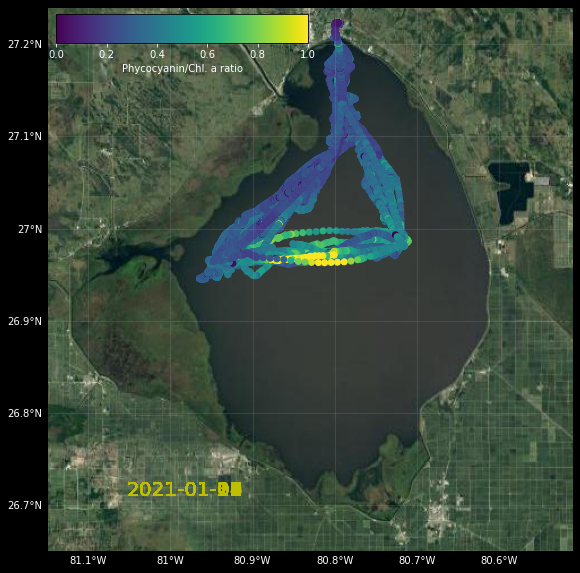

In [35]:
subset = local.df[(local.df['local time'].dt.year == 2021)&(local.df['local time'].dt.month == 4)]

# request = cimgt.GoogleTiles(style='satellite')
back_color='black'
fore_color='white'
plt.rcParams["text.color"] = fore_color
plt.rcParams["axes.labelcolor"] = fore_color
plt.rcParams["xtick.color"] =  fore_color
plt.rcParams["ytick.color"] = fore_color


fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=request.crs)
fig.patch.set_facecolor(back_color)

cax = fig.add_axes([.16, .83, .35, .04])
camera = Camera(fig)

local.background(ax=ax, request=request)
for d in range(1,31):
#     if d>1:
#         mpp.remove()
    day = subset[subset['local time'].dt.day == d]

    mpp = ax.scatter(day['Lon'], day['Lat'],
               c=day['Phycocyanin [ppb]']/day['Chl. a [ppb]'],
               vmin=0, vmax=1.,
               transform=ccrs.PlateCarree(),)
    
    if day.shape[0]>0:
        date = day['local time'].iloc[0]
    else:
        date += timedelta(days=1)

    ax.text(.15, .1, str(date)[:-15], fontsize=20, c='y', transform=ax.transAxes)
    fig.colorbar(mpp, cax=cax,orientation='horizontal', label='Phycocyanin/Chl. a ratio')
    camera.snap()


In [36]:
anim = camera.animate(interval=1000)
anim.save('Jan_pcratio.mp4')
HTML(anim.to_html5_video())

/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


In [11]:
# import cartopy.feature as cfeature
# from cartopy.io.img_tiles import Stamen
# def background(extent = [-81.15, -80.51,26.65, 27.24], ax=None, 
#               request = cimgt.GoogleTiles(style='satellite'),
#              out = False):
#     if request:
#         projection = request.crs
#         grid = True
#         image = request
#         zoom = 10
# #         features = False
#     else:
#         projection = ccrs.LambertConformal(central_longitude=-80.83, central_latitude=26.95,)
#         grid = False
#         image = Stamen(style='terrain-background)')
#         zoom = 10
# #         image = False
# #         features = True
        
#     if ax is None:
#         fig = plt.figure(figsize=(10, 10))
#         ax = plt.axes(projection=projection)

#     ax.set_extent(extent)
#     ax.add_image(image, zoom)    
# #     if features:
# #         ax.add_feature(cfeature.NaturalEarthFeature(category='raste',
# #                                                     name='natural_earth_1',
# #                                                     scale='10m'))
# # #         ax.add_feature(cfeature.NaturalEarthFeature(category='physical',
# # #                                                     name='Lakes',
# # #                                                     scale='10m'))
# # #         ax.add_feature(cfeature.NaturalEarthFeature(category='physical',
# # #                                                     name='rivers_lake_centerlines',
# # #                                                     scale='10m'))
      
#     if grid:
#         gl = ax.gridlines(draw_labels=True, alpha=0.2)
#         gl.xlabels_top = gl.ylabels_right = False
#         gl.xformatter = LONGITUDE_FORMATTER
#         gl.yformatter = LATITUDE_FORMATTER


#     if out is True:
#         return fig, ax
#     return fig, ax

In [114]:
anim = camera.animate()

In [116]:
HTML(anim.to_html5_video())

/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


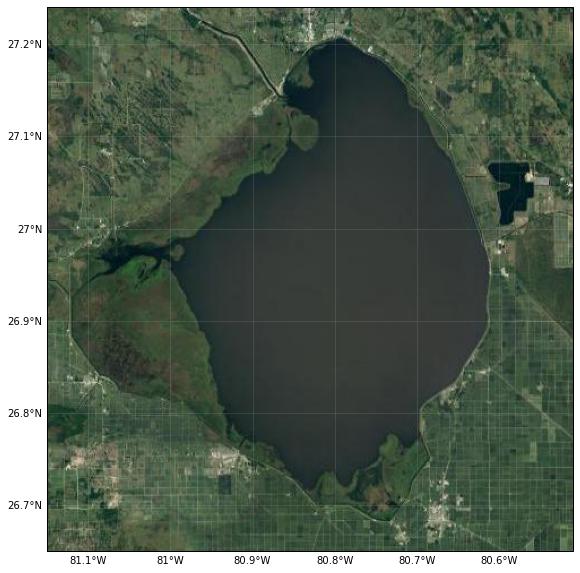

In [155]:
request = cimgt.GoogleTiles(style='satellite')
subset = frame[frame['local time'].dt.month == 1]
fig, ax = sb.background(out=True)
camera = Camera(fig)
markers = []
for index, row in subset[500:400].iterrows():
#     print(index)
    mrk = ax.scatter(row['Lon'], row['Lat'], c=row['Phycocyanin [ppb]']/row['Chl. a [ppb]'],
                              transform=ccrs.PlateCarree(),
                              vmin=0, vmax=2.)
#     markers.append(mrk)
#     if len(markers)>10 :
#         markers[0].remove()
#         del markers[0]
        
    camera.snap()

In [135]:
animation.save('animation.mp4')

/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


AttributeError: 'NoneType' object has no attribute 'canvas'

In [165]:
day = subset[subset['local time'].dt.day == 1]
day

,GPSTimeStamp,Lon,Lat,O2 Concentration [micromolar],O2 Saturation [%],Bb(470) [NTU],Bb(532) [NTU],Bb(650) [NTU],CDOM [QSU],Chl. a [ppb],Phycocyanin [ppb],local time
Id,,,,,,,,,,,,
111027,2021-01-01 19:54:25,-80.879128,26.975124,0.0,0.0,31.971,35.206,-11.645,191.44,18.30,6.79,2021-01-01 23:54:25+04:00
111026,2021-01-01 19:44:17,-80.882141,26.974848,0.0,0.0,30.275,33.507,-11.645,196.09,19.63,6.97,2021-01-01 23:44:17+04:00
111025,2021-01-01 19:34:21,-80.885178,26.974648,0.0,0.0,29.306,32.293,-11.645,197.66,17.79,7.66,2021-01-01 23:34:21+04:00
111024,2021-01-01 19:24:21,-80.888000,26.974363,0.0,0.0,28.338,30.836,-11.645,201.56,17.88,7.37,2021-01-01 23:24:21+04:00
111023,2021-01-01 19:14:19,-80.890594,26.974052,0.0,0.0,27.853,30.593,-11.887,201.91,17.53,7.16,2021-01-01 23:14:19+04:00
...,...,...,...,...,...,...,...,...,...,...,...,...
105092,2020-12-31 20:00:51,-80.797417,27.207148,0.0,0.0,18.892,21.124,-11.887,206.18,19.63,3.80,2021-01-01 00:00:51+04:00
105091,2020-12-31 20:00:42,-80.797417,27.207144,0.0,0.0,18.892,21.124,-11.887,206.18,19.63,3.80,2021-01-01 00:00:42+04:00
105090,2020-12-31 20:00:31,-80.797417,27.207148,0.0,0.0,18.892,21.124,-11.887,206.18,19.63,3.80,2021-01-01 00:00:31+04:00


In [162]:
anim = camera.animate()
HTML(anim.to_html5_video())

In [163]:
HTML(anim.to_html5_video())

/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
